<a href="https://colab.research.google.com/github/thibaudjoel/StochasticVariationalInference/blob/main/stoch_var_inf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook created for the course "Simulation Methods for Generative Models" @ Sorbonne Université**

**Authors: Thibaud Hadamczik & Guillhem Artis**

# Introduction

In this notebook, we present Stochastic Variational Inference (SVI) and apply it to Latent Dirichlet allocation in the context of Topic Models. It is based on ([Hoffmann et al., 2013](https://jmlr.org/papers/v14/hoffman13a.html)). We will first motivate SVI in a general setting and discuss how the assumptions made in that setting allow for an efficient implementation of a stochastic optimization algorithm. Subsequently we give the concrete form of SVI in the context of Topic Models, more specifically Latent Dirichlet Allocation (LDA). After that, we implement SVI for LDA and analyze the behavior when applied to a large text corpus.




# Setting

We will consider a family of graphical models, whose density can be written as

$$
p(x,z,\beta|\alpha)= p(\beta|\alpha)\prod_{n=1}^N p(x_n,z_n|\beta),
$$

with the following meanings:

- $\alpha$ is a vector of fixed parameters
- $\beta$ is a vector of global hidden variables
- $x=x_{1:N}$ correspond to $N$ observations
- $z=z_{1:N}$ correspond to $N$ local hidden variables each (potentially) being a collection of variables

This formulation implies independence of one pair of observation and associated hidden variable ($x_n$, $z_n$) from the other pairs when conditioning on the global parameter $\beta$.

The goal is to infer the hidden parameters given observations $x$, i.e. to estimate the posterior distribution when conditioning on the observations:

\begin{equation}
p(\beta, z|x) = \frac{p(x, z, \beta)}{p(x)} = \frac{p(x, z, \beta)}{\int p(x, z, \beta) \, dzd\beta}.
\end{equation}

Computing this posterior would allow us to explore the data and make predictions for new data points.
However, direct computation of this posterior can be challenging due to the intractable integral involved in the denominator.

# Stochastic Variational Inference

## Variational Inference
Variational Inference (VI) is one possible approach to tackle the problem of the uncomputable posterior.  Therefore one introduces a family of approximate distributions $q(\beta, z | \alpha, \eta)$, parameterized by $\alpha$ and $\eta$.

The idea is to choose a rich family with convenient properties and to find the candidate in this family which is closest to the real posterior. We now derive the Evidence Lower Bound (ELBO) in our setting by manipulating the expression for the marginal likelihood of the observed data:


\begin{align*}
\log p(x) &= \log \int p(x, z, \beta) \, dzd\beta \\
          &= \log \int p(x, z, \beta) \frac{q(z, \beta|\alpha, \eta)}{q(z, \beta|\alpha, \eta)} \, dz d\beta\\
          &= \log \mathbb{E}_{Z \sim q(\cdot|\alpha, \eta)} \left[ \frac{p(x, Z, \beta)}{q(\beta, Z|\alpha, \eta)} \right] \\
          &\geq \mathbb{E}_{Z \sim q(\cdot|\alpha, \eta)} \left[ \log \frac{p(x, Z, \beta)}{q(Z, \beta|\alpha, \eta)} \right] \quad (\text{Jensen's Inequality}) \\
          &= \mathbb{E}_{Z \sim q(\cdot|\alpha, \eta)} [\log p(x, Z, \beta) - \log q(\beta, z|\alpha, \eta)] \\
          &\overset{\Delta}{=} \mathcal{L}(q).
\end{align*}

The ELBO $\mathcal{L}(q)$ serves as a lower bound on the  marginal log-likelihood $\log p(x).$

Maximizing the ELBO with respect to the parameters of the variational family will improve our approximation to the true posterior since it is equivalent to minimizing the Kullback-Leibler ($KL$) divergence between the variational distribution $q(\beta, z|\alpha, \eta)$ and the true posterior $p(\beta, z|x).$ The $KL$ divergence is given by:
$$
KL(q(\beta, z|\alpha, \eta) \| p(\beta, z|x)) = \mathbb{E}_{Z \sim q(., \beta|\alpha, \eta)} \left[ \log \frac{q(Z, \beta|\alpha, \eta)}{p(Z, \beta|x)} \right],
$$

which can be written in terms of the ELBO as

$$
 KL\left((q(\beta, z|\alpha, \eta) \| p(\beta, z|x)\right) = \log p(x) - \mathcal{L}(q)
$$

In classic variational inference the maximization of $\mathcal{L}(q)$ is typically performed using a coordinate ascent algorithm, which iterates between re-analyzing every data point in the data and re-estimating its hidden structure, which is computationally expensive and not viable when working with very large datasets.

Before going into the details of how we can make the usual gradient ascent procedure more efficient, we will specify the variational family by which we want to approximate the posterior distribution $p(\beta, z|x)$.

## Exponential families

A particular choice of the variational family will turn out to have nice properties. If we choose as variational family the  distributions whose complete conditional distributions can be written as

$$
p(\beta|x,z,\alpha) = h(\beta)\exp(\eta_g(x,z,\alpha)^Tt(\beta)−a_g(\eta_g(x,z,\alpha)),
$$

$$
p(z_{nj} |x_n,z_{n,−j},\beta) = h(z_{nj})exp(\eta_l(x_n,z_{n,−j},\beta)^Tt(z_{nj})−a_l(\eta_l(x_n,z_{n,−j},\beta))),
$$

i.e. being in the exponential family (EF), this has in particular the following implication:

- The prior distribution $p(\beta)$ must be in the EF and (by conjugacy) the complete conditional for $\beta$ is in the same EF as the prior with natural parameter

$$\eta_g(x,z,\alpha) = ( \alpha_1 + \sum_{n=1}^N = t(z_n,x_n), \alpha_2+N).$$

The use of EFs will allow for an easy expression of the natural logarithm of the ELBO.


Next we introduce the mean field variational family

$$q(z,\beta) = q(\beta|\lambda) \prod_{n=1}^N \prod_{j=1}^J q(z_{nj} | \varphi_{nj}),$$

which is indexed by the global parameters $\lambda$ and local parameters $(\phi_{nj})$ separately controlling the marginal distributions of the global and local variables, respectively.

Combining mean field and exponential family we obtain

$$q( \beta | \lambda ) = h(\beta) \exp (\lambda^T t(\beta) -a_g(\lambda))$$

$$q(z_{nj} | \phi_{nj}) = h(z_{nj}) \exp (\phi_{nj}^T t(z_{nj}) - a_l(\phi_{nj})).$$

It turns out, that in this case the gradient of the ELBO vanishes for the choices

$$\lambda = \mathbb{E}_q[\eta_g(x,z,\alpha)].
$$

$$\phi_{nj} = \mathbb{E}_q[\eta_l(x_n,z_{n,−j},\beta)].
$$

such that the local parameters do not depend on the the local parameters which are not in the same context, which leads to a coordinate ascent algorithm that iterates between updating the global parameter $\lambda$ and *all* local parameters $\phi_{nj}$.


This is inefficient for large datasets, such as corpora of text documents, because it requires a full pass on the data at each iteration to update the local parameters. A natural idea would be to subsample at each iteration and to perform a noisy estimate of the gradient, on which we "ascent".


Hoffmann et al. therefore propose SVI, i.e. the use of stochastic (Robbins-Monro type) algorithms applied to the VI maximization problem.

Before we get to that, we present the natural gradient.

## The natural gradient of the ELBO

While the classical gradient implicitly depends on the Euclidean distance metric associated with the parameter spaces, the natural gradient of a function takes into account the information geometry of its parameter space, using a Riemannian metric to adjust the direction of the traditional gradient. The construction of a Riemannian metric on probability spaces is beyond our scope. We refer to the paper  [Chentsov's theorem for exponential families](https://arxiv.org/abs/1701.08895) (Dowty, 2018). To provide some intuition on the construction, the set of all exponential family distributions parameterized by $\lambda$ forms a smooth submanifold in the set of all probability distributions. In each tangent space, the Fisher information matrix is symmetrically positive definite and thus defines an inner product that extends to a tensor on the tangent bundle. This submanifold of exponential families (within the finite-dimensional vector space of the parameters) endowed with this tensor defines a Riemannian metric called the Fisher metric. The natural gradient of a function in the space of $\eta$ is defined as:
$$ \hat{\nabla}_\lambda \overset{\Delta}{=} G_\lambda (\lambda)^{-1} \nabla_{\lambda} f_\eta$$
where $\nabla_\lambda$ is the classical gradient operating on smooth exponential distributions (seen as vectors in the Hilbert space $L^2$) on the parameter space and $G(\lambda)$ is the Fisher information of $q(\lambda)$:
$$G(\lambda) = \mathbb{E}_\lambda \left [ \| \nabla_{\eta} \log (q(\beta | \lambda ))\|^2 \right ].$$

In the context of exponential families, the natural gradient takes this specific form.

To motivate the use of natural gradients, the article Symplectic Structures on [Statistical Manifolds](https://www.cambridge.org/core/journals/journal-of-the-australian-mathematical-society/article/symplectic-structures-on-statistical-manifolds/A0AF57C23C3B06607E7D88676A10449A) (Noda, 2011) explains the relationship between this Riemannian metric and the Kullback-Leibler divergence. The natural gradient points in the direction of increasing divergence information regions, thus performing an ascent would improve the approximation of the conditional posterior. However, the article by Hoffman et al. place greater emphasis on the computational simplifications. In particular, using the fact that one can obtain the natural gradient from the gradient with respect to the Euclidean metric by premultyplying it with the inverse Fisher information, leads to canceling out of the Fisher information matrix which is the first term in the usual gradient of the ELBO.

## Stochastic Optimization

Instead of computing the gradient of the ELBO using the entire dataset, in SVI, the idea is to estimate the gradient using a randomly selected (and unbiased) data point $x_t$ at each iteration. This significantly reduces computational costs. Using natural gradients in a Robbins-Monro algorithm, the stochastic gradient update at iteration $t$ can be formulated as
$$\lambda^t = \lambda^{t-1} + \rho_t (\hat{\lambda}^t - \lambda^{t-1})$$
where $\rho_t$ is the learning rate, which should satisfy the decreasing step assumptions,
- $\sum_{t = 1} ^{\infty} \rho_t = \infty$,
- $\sum_{t = 1} ^{\infty} \rho_t^2 < \infty$,

and can be parameterized as $\rho_t =(t+\tau)^{−\kappa}$ with delay $\tau$ downweighting earlier iterations and forgetting rate $\kappa$ determining the speed with which old information is forgotten.

Here $\hat{\lambda}$ is the intermediate global parameter defined as the estimate of $\lambda$ that would be obtained if the sampled data point were replicated $N$ times. An explicit expression can be obtained thanks to the assumptions on the variational family and reads as

$$
\hat{\lambda}^t \overset{\Delta}{=} \alpha+N\mathbb{E}_{\varphi_i(\lambda)}[(t(x_i,z_i),1)]
$$


The SVI algorithm hence follows these steps:

1. Initialize parameters $\lambda^{(0)}$
2. For each iteration $t$:
    1. Randomly select a data point $x_i$
    2. Compute the local variational parameter $\phi$ that minimizes the ELBO for $\lambda^{(t-1)}$ fixed
    3. Set $\hat{\lambda}^t \overset{\Delta}{=} \alpha+N \mathbb{E}_{\phi}[(\eta_g(x^{(N)},z^{(N)})]$
    4. Update the parameters using the stochastic gradient and learning rate

$$\lambda^t = \lambda^{t-1} + \rho_t (\hat{\lambda}^t - \lambda^{t-1})$$

3. Repeat until a convergence criterion or a specified number of iterations is reached.

The convergence in probability and with respect to the $L^2$ norm to a (local) optimum is ensured under the general assumptions of the Robbins-Monro type algorithm.

# Application to Topic Models

Now we want to apply SVI to an explicit setting. Given a large corpus of documents, topic models are probabilistic tools used to discover the underlying thematic structures within these documents. The fundamental premise of topic modeling is that a set of latent topics exists which collectively describes the corpus, with each document exhibiting these topics to varying degrees. The primary computational challenge is to infer this hidden structure from the observed data in the document collection. We will focus on a prominent model: Latent Dirichlet Allocation (LDA). This model provides a framework for understanding the distribution of topics within documents and across the corpus.

## LDA Modelization

The documents we observe in the corpus are composed of words of a fixed vocabulary of cardinal $V$. The n-th word in document $d$ is denoted by $w_{dn}$, for $d=1,\dots,D$ and $n=1,\dots,N$, such that $D$ is the number of documents and $N$ the number of words in the document (implicitly $N=N(d)$ depends on $d$).


In a topic model, each document can be described by $K$ topics $\beta_k$, which are distributions on the words of the vocabulary the topic proportions of the document which states to which extent the document exhibits the different topics (documents can belong to several topics at once, this is called mixed membership). The distribution of a word occuring in a document is therefore given by a mixture of the topic distributions on the words.

Denoting by $\beta_{kw}\geq0$ the probability of word $w$ under topic $k$, we have $\sum_{v=1}^V\beta_{kv} =1$ for $k=1,\dots,K$ such that each $\beta_k$ is a point on the $V-1$ simplex. Similarly the topic proportions $\theta_d$ of document $d$ are points on the $K-1$ simplex. Furthermore we denote by $z_{dn}$ the topic assignment of word $n$ in document $d$ (takes values in \{1,\dots,K\}).

In LDA one places Dirichlet priors with parameters $\eta$ and $\alpha$ on $\beta_k$ and $\theta_d$. If we assume exchangeable Dirichlet priors, we obtain the following joint distribution:

$$p(w, z, \theta, \beta ; \alpha, \eta) = \underbrace{\prod_{k=1}^{K} \underbrace{ p(\beta_k , \eta)}_{\textrm{topics}} \prod_{d =1}^D \underbrace{p(\theta_d, \alpha)}_{\textrm{documents}}}_{\textrm{Dirichlet distributions}} \underbrace{\prod_{n=1}^{N} \underbrace{p(z_{dn} , \theta_d)}_{\textrm{topics}} \underbrace{p(w_{dn} | z_{dn}, \beta_d)}_{\textrm{words}}}_{\textrm{Multinomial distributions}}.$$

## SVI applied to LDA

The goal is now to make inference on the posterior distribution $p(\beta,\theta,z|w)$, which would in particular allow us to make statements about the topics that describe the corpus and the topic assignments of the documents. With our modelization, the complete conditional of the topic assignment of a word is a mixture of multinomials and hence multinomial,

$$
p(z_{dn} = k|\theta_d,\beta_{1:K},w_{dn})\propto \exp(\log\theta_{dk}+\log\beta_k,w_{dn}).
$$

while the complete conditionals of the topic assignments are Dirichlet

$$
p(\theta_d |z_d) = \operatorname{Dirichlet}\left(\alpha+\sum_{n=1}^N z_{dn}\right).
$$

and the complete conditional for the topic $\beta_k$ is  Dirichlet,

$$p(\beta_k |z,w) = \operatorname{Dirichlet}\left(\eta+\sum_{d=1}^D \sum_{n=1}^N z^k_{dn}w_{dn}\right).$$

The complete conditionals are in the EF such that we can apply the results of the previous chapter:

- Variational distribution of the topic assignment of a word is multinomial

$$q(z_{dn}) = \operatorname{Multinomial}(\varphi_{dn}),$$ with $\varphi_{dn}$ a point on the $K-1$-simplex

- Variational distribution of the topic proportions of a document is Dirichlet,

$$q(\theta_d) = \operatorname{Dirichlet}(\gamma_d),$$ with $\gamma_d$ $K$-dimensional Dirichlet parameter

- Variational distribution of the topics are $V$-dimensional Dirichlet, $$q(\beta_k) = \operatorname{Dirichlet}(\lambda_k)$$

Using the mean-field assumption, the specific shapes of the variational distributions and the results of the previous chapter in the general setting, the updates of the local parameters for SVI with the natural gradient in LDA are given by

 $$\varphi^k_{dn} \propto \exp\left(\Psi(\gamma_{dk})+\Psi(\lambda_{k,w_{dn}})−\Psi\left(\sum_{v=1}^V\lambda_{kv}\right)\right),\text{  for } n=1,\dots,N$$
 $$\gamma_d = \alpha + \sum_{n=1}^N \varphi_{dn},$$
 with $\Psi$ denoting the derivative of the log Gamma function.

The update of the global parameters reads as

 $$\lambda_k = \eta + \sum_{d=1}^D\sum_{n=1}^N \varphi^k_{dn}w_{dn}.$$

This finally leads to the following algorithm:

1. Initialize $\lambda^{(0)}$ randomly.
2. For each iteration $t$
    1. Sample a document $w_d$ uniformly from the data set.
    2. Initialize $\gamma_{dk} = 1$, for $k = 1,\dots,K$.
    3. Repeat until convergence:
        1. For $n = \{1,\dots,N\}$
             $$\varphi_{dn}^k \propto \exp(\mathbb{E}[\log\theta_{dk}]+\mathbb{E}[\log\beta_k,w_{dn}]), k = 1,\dots,K$$
        2. Set $\gamma_d = \alpha+\sum_{n=1}^N\varphi_{dn}$.
3. For $k= 1,\dots,K$ set intermediate topics $$\lambda^k = \eta + D \sum_{n=1}^N  \varphi^k_{dn} w_{dn}$$
4. Set $\lambda_t =(1−\rho_t)\lambda^{(t−1)}+\rho_t\hat{\lambda}$.

In the next chapter we will implement this algorithm but remark that many extensions are possible, in particular a hierarchical Bayes approach presented in the paper of Hoffmann et al.


# Implementation of SVI for LDA

In this section we will illustrate the SVI algorithm in the context of LDA for subset of the English Wikipedia corpus.

## Installations & Imports

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import time

from datasets import load_dataset
from tqdm.notebook import tqdm
from scipy.special import psi
from sklearn.feature_extraction.text import CountVectorizer

## Data Loading & Preprocessing

We load our data set from Hugging face

In [ ]:
dataset = load_dataset("wikipedia", "20220301.en", split='train')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for wikipedia contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wikipedia
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Downloading:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/20.3G [00:00<?, ?B/s]

We shuffle the dataset, since we will not use the whole corpus.

In [ ]:
dataset = dataset.shuffle(seed=42)

In [ ]:
len(dataset)

6458670

The total number of documents in the data set is over 6 million. We will only use a subset of 300k.

In [ ]:
dataset[0]

{'id': '11663875',
 'url': 'https://en.wikipedia.org/wiki/William%20Whitehouse',
 'title': 'William Whitehouse',
 'text': "William Edward Whitehouse (20 May 1859 – 12 January 1935) was an English cellist.\n\nCareer\nHe studied for one year with Alfredo Piatti, for whom he deputised (taking his place in concerts when called upon), and was his favourite pupil. He went on to teach at the Royal Academy of Music, Royal College of Music and King's College, Cambridge; his students included Felix Salmond and Beatrice Harrison, who both became closely associated with Edward Elgar. He played with violinist Joseph Joachim, and formed The London Trio with violinist Achille Simonetti and pianist Amina Goodwin. He edited Piatti's Caprices, with suggestions as to how his former teacher preferred them to be played.\n\nExternal links\n William Whitehouse\n The Violoncello and the Romantic Era: 1820-1920: Part II — A Survey of Current Cello Teachers on Romantic Repertoire and Aesthetics\n\n1859 births\n

We select the first 302k entries of the shuffled dataser and split into documents which we want to fit our model on and held out documents, which we want to use to evaluate the performance.

In [ ]:
docs = dataset[:302000]['text']

In [ ]:
test_docs = docs[300000:]
docs = docs[:300000]

For the algorithm the number of occurrences of each word in each of the document is all the information needed. We will store this information in a $DxV$ Document Term Matrix (DTM), where each row corresponds to one document and each column to one words in the vocabulary. The entry $(d,v)$ of the DTM tells us how many times word $v$ of the vocabulary appeared in document $d$.

We create the DTM from our dataset. We exlude words that appeared in less than 2% of the documents and words that appeared in more than 80% of the documents from the vocabulary and simultaneously preprocess the data
- to lowercase
- remove punctuation
- filter out words with less than three charactes
- remove stopwords

In [ ]:
cut_off = 0.02
max_df = 0.8

# Initialize CountVectorizer
vectorizer = CountVectorizer(lowercase=True, stop_words='english', token_pattern=r"(?u)\b[a-zA-Z]{3,}\b", min_df=cut_off, max_df=max_df)

# Fit the vectorizer and transform the documents into a document-term matrix
dtm = vectorizer.fit_transform(docs)

# transform the test documents into a document-term matrix
test_dtm = vectorizer.transform(test_docs)

# Get the terms (words) in order corresponding to columns of the DTM
terms = vectorizer.get_feature_names_out()

In [ ]:
dtm.shape

(300000, 1301)

The final vocabulary has a size of $V=1301$ words.

## Implementation



There exist different methods to evaluate the performance of the algorithm, we will use the predictive loglikelihood.
Given held out documents, we fit the topic proportions of the document with one part of the words, $w_{obs}$ in the document. Then one can compute the probability of the words $w_{new}$ which were not used to fit the topic proportions conditionally on the training set $\mathcal{D} and $w_{obs}$ using the following approximative formula, which is valid if the variational distributions are close enough to the real distributions:

$$
p(w_{new}|\mathcal{D},w_{obs}) = \sum_{k=1}^K \mathbb{E}_q[\theta_k]\mathbb{E}_q[\beta_k,w_{new}].
$$

In [ ]:
def log_pred_lh(lamb, test_dtm, ind_hidden, ind_observed, alpha, eps):
    """
    Compute the log predictive likelihood of hidden words in documents given the training data and the observed words.

    Parameters:
    lamb (numpy.ndarray): The topic-word distribution matrix.
    test_dtm (scipy.sparse.csr_matrix): The document-term matrix for test data.
    ind_hidden (list): List of indices corresponding to hidden words.
    ind_observed (list): List of indices corresponding to observed words.
    alpha (float): Dirichlet parameter for the document-topic distribution.
    eps (float): Convergence threshold for the iterative computation.

    Returns:
    float: The log predictive likelihood.

    The function iteratively estimates the topic proportions and word-topic assignments for each document
    using variational inference. It then computes the log probabilities of the hidden words in the documents
    given the training data and the observed words. Finally, it calculates the total predictive log likelihood
    by multiplying the log probabilities with the word counts and summing over all documents.
    """

    # initialization
    gamma = np.zeros((test_dtm.shape[0], K))
    Elog_theta = np.zeros((test_dtm.shape[0], K))
    Elog_beta = psi(lamb) - np.sum(psi(lamb), axis=1).reshape(-1,1)
    # compute topic proportions for each document based on observed words
    for d in range(test_dtm.shape[0]):
        # Get the word counts for the observed words in document
        words_d_counts = test_dtm[d, ind_observed]

        # initialize array with topic proportions of the current document
        gamma_d_t = np.ones((K,1))

        # number of unique words in the document
        N = words_d_counts.nnz

        # skip documents without words
        if N == 0:
            gamma[d, :] = 1
            continue

        # indices of unique observed words
        words_ind = words_d_counts.nonzero()
        words_d_counts = np.array(words_d_counts[words_ind])
        words_ind = words_ind[1]

        # matrix containing topic assignments for words in current document
        Phi_t = np.zeros((K, N))
        gamma_d = gamma_d_t + 3
        Phi = Phi_t + 3

        for _ in range(100):
            gamma_d = gamma_d_t
            Phi = Phi_t

            # update array with the parameters of the (multinomial) word distribution for doc d
            # this is supposed to be KxN matrix
            Elog_theta_d = psi(gamma_d) - np.sum(psi(gamma_d))
            Elog_beta_d = Elog_beta[:, words_ind]

            log_N = Elog_theta_d + Elog_beta_d
            shift = np.max(log_N).reshape(1,-1)
            log_D = shift + np.sum(np.exp(log_N-shift), axis=0)
            Phi_t = np.exp(log_N-log_D)

            # scale by number the word occurs in the document
            Phi_t *= words_d_counts

            if np.max([np.linalg.norm(gamma_d-gamma_d_t, ord=2), \
                       np.linalg.norm(Phi-Phi_t, ord=2)]) < eps:
                break

        gamma_d_t = alpha + np.sum(Phi_t, axis=1).reshape(-1,1)
        gamma[d, :] = gamma_d_t.flatten()

    # normalize gamma to get topic distributions of the documents
    gamma_norm = gamma / np.sum(gamma, axis=1).reshape(-1,1)+1e-100

    # normalize lambda to get topic distributions on words
    lamb_norm = lamb / np.sum(lamb, axis=1).reshape(-1,1)

    # log probabilities of hidden words in the documents given the training data and the observed words
    log_probs = np.log(gamma_norm @ lamb_norm[:, ind_hidden])

    # multiply with word counts to get total predictive log likelihood
    pred_log_likelihood = 0
    for d in range(test_dtm.shape[0]):
        counts = test_dtm[d, ind_hidden].toarray()
        pred_log_likelihood += np.nansum(np.multiply(log_probs[d, :],counts))

    return pred_log_likelihood

The following function implements the SVI algorithm for LDA

In [ ]:
def svi_lda(dtm, test_dtm, ind_hidden, ind_observed, K=3, n_it=10000, alpha=1, eta=0.01, forgetting_rate=.3, delay=1, eps=1e-3, track_likelihood=False, evaluation_interval=2000):
    """
    Stochastic Variational Inference for Latent Dirichlet Allocation (SVI-LDA) algorithm.

    Parameters:
    dtm (scipy.sparse.csr_matrix): Document-term matrix of shape (number of documents, vocabulary size).
    test_dtm (scipy.sparse.csr_matrix): Document-term matrix for test data.
    ind_hidden (list): List of indices corresponding to hidden words (for evaluation of predictive likelihood).
    ind_observed (list): List of indices corresponding to observed words (for evaluation of predictive likelihood).
    K (int): Number of topics (default is 3).
    n_it (int): Number of iterations (default is 10000).
    alpha (float): Dirichlet parameter for document-topic distribution (default is 1).
    eta (float): Dirichlet parameter for topic-word distribution (default is 0.01).
    forgetting_rate (float): Rate at which the learning rate decays (default is 0.3).
    delay (int): Delay parameter for learning rate decay (default is 1).
    eps (float): Convergence threshold (default is 1e-3).
    track_likelihood (bool): Whether to track predictive likelihood during training (default is False).
    evaluation_interval (int): Interval for evaluating and storing likelihood (default is 2000).

    Returns:
    tuple: Tuple containing:
        - numpy.ndarray: Updated topic-word distribution matrix.
        - numpy.ndarray: Predictive log likelihoods at evaluation intervals.
        - numpy.ndarray: Elapsed times at evaluation intervals.

    This function implements the Stochastic Variational Inference for Latent Dirichlet Allocation (SVI-LDA) algorithm.
    It estimates the topic-word distribution using a stochastic gradient ascent method.
    The learning rate is adaptively adjusted based on the number of iterations and a decay parameter.
    Optionally, it tracks predictive log likelihoods during training and returns them along with elapsed times.
    """
    # extraction of corpus and vocabulary size from the DTM
    D, V = dtm.shape

    # initialize lambda randomly
    lamb_t =  eta + np.random.default_rng(seed=42).exponential(scale=1/(D * 100/(K*V)), size=(K, V))

    # here we will store the predictive log likelihoods and the elapsed times
    log_pred_lhs = np.zeros(n_it//evaluation_interval)
    times = np.zeros(n_it//evaluation_interval)

    start_time = time.time()
    rng = np.random.default_rng(seed=1213)
    for t in tqdm(range(n_it)):
        # Choose a random document index as the row number of its entry in the document term matrix
        words_d_idx = rng.choice(range(D))

        # Get the word counts for the sampled document
        words_d_counts = dtm[words_d_idx]

        # number of unique words in the document
        N = words_d_counts.nnz

        # skip documents without words
        if N == 0:
            continue

        # indices of unique words in lambda/ DTM
        words_ind = words_d_counts.nonzero()
        words_d_counts = np.array(words_d_counts[words_ind])
        words_ind = words_ind[1]

        # initialize array with topic proportions of the current document
        gamma_d_t = np.ones((K,1))

        # matrix containing topic assignments of words in current document
        Phi_t = np.zeros((K, N))

        for _ in range(200):
            gamma_d_old = gamma_d_t
            Phi_old = Phi_t

            # update array with the parameters of the (multinomial) word distribution for doc d
            Elog_theta_d = psi(gamma_d_t) - np.sum(psi(gamma_d_t))
            Elog_beta = psi(lamb_t[:, words_ind]) - np.sum(psi(lamb_t), axis=1).reshape(-1,1)

            log_N = Elog_theta_d + Elog_beta

            # use log-sum-exp trick to avoid overflow
            shift = np.max(log_N, axis=0).reshape(1,-1)
            log_D = shift + np.sum(np.exp(log_N-shift), axis=0)
            Phi_t = np.exp(log_N-log_D)

            # scale by number the word occurs in the document
            Phi_t *= words_d_counts

            # update
            gamma_d_t = alpha + np.sum(Phi_t, axis=1).reshape(-1,1)

            # stop if local parameters have converged
            if np.max([np.linalg.norm(gamma_d_old-gamma_d_t, ord=2), \
                       np.linalg.norm(Phi_old-Phi_t, ord=2)]) < eps:
                break

        # set learning rate of current iteration
        rho_t = (t+1+delay)**(-forgetting_rate)

        # update parameters differentiating between parameters corresponding to
        # words in current document and remaining parameters
        lamb_t = (1-rho_t)*lamb_t + rho_t * eta
        lamb_t[:, words_ind] = lamb_t[:, words_ind] + rho_t * D * Phi_t

        # calculate and store predictive log likelihoods with the current parameters and store the times
        # if tracking is activated
        if track_likelihood:
            if t % evaluation_interval == 0:
                log_pred_lhs[t//evaluation_interval] = log_pred_lh(lamb_t, test_dtm, ind_hidden, ind_observed, alpha, eps)
                times[t//evaluation_interval] = time.time() - start_time
                print(log_pred_lhs[t//evaluation_interval])

    return lamb_t, log_pred_lhs, times

# Experiments

We choose to run SVI for LDA for each combination of forgetting rates $\kappa \in \{0.6, 0.75, 0.9\}\}$ and number of topics $K \in \{25, 50, 75\}$ for T=150.000 iterations. Performance is assessed via the predictive loglikelihood defined above on 2000 held out documents where a random half of the vocabulary is observed and the other half hidden. We compute the predictive likelihood every 2000 iterations. To make the results comparable we fix random generators to have the same initializations and the same sequence of randomly chosen documents in each run. Of course one could investigate the behaviour of the algorithm with respect to many more parameter, not only the parameters of the algorithm itself but also the ones relating to the preprocessing of the corpus (e.g. the cutoff). We focus on $K$ and $\kappa$ since we deem them to be the most important ones and their impact is intuitively understandable.

In [ ]:
# get random indices in DTM of hidden words
ind_hidden = np.random.default_rng(18).choice(dtm.shape[1], size=dtm.shape[1]//2, replace=False)

# deduce the indices of the observed words
ind_observed = [i for i in np.arange(dtm.shape[1]) if i not in ind_hidden]

# save results of the runs in dictionary
result_dict = {}
setting = 0
for forgetting_rate in [0.6, 0.75, 0.9]:
    for K in [25, 50, 75]:
        result, log_pred_lhs, times = svi_lda(dtm, test_dtm, ind_hidden, ind_observed, K=K, n_it=150000, alpha=1/K, eta=1/K, forgetting_rate=forgetting_rate, delay=1, eps=1e-3, track_likelihood=True)
        result_dict[setting] = {'K': K,
                               'forgetting_rate': forgetting_rate,
                               'lambda': (result / np.sum(result, axis=1).reshape(-1,1)).tolist(),
                               'log_pred_lhs': log_pred_lhs.tolist(),
                               'times': times.tolist()}
        setting += 1

In [ ]:
# load the arrays of the predictive likelihoods
kappa_06_K_25 = result_dict['0']['log_pred_lhs']
kappa_06_K_50 = result_dict['1']['log_pred_lhs']
kappa_06_K_75 = result_dict['2']['log_pred_lhs']
kappa_075_K_25 = result_dict['3']['log_pred_lhs']
kappa_075_K_50 = result_dict['4']['log_pred_lhs']
kappa_075_K_75 = result_dict['5']['log_pred_lhs']
kappa_09_K_25 = result_dict['6']['log_pred_lhs']
kappa_09_K_50 = result_dict['7']['log_pred_lhs']
kappa_09_K_75 = result_dict['8']['log_pred_lhs']

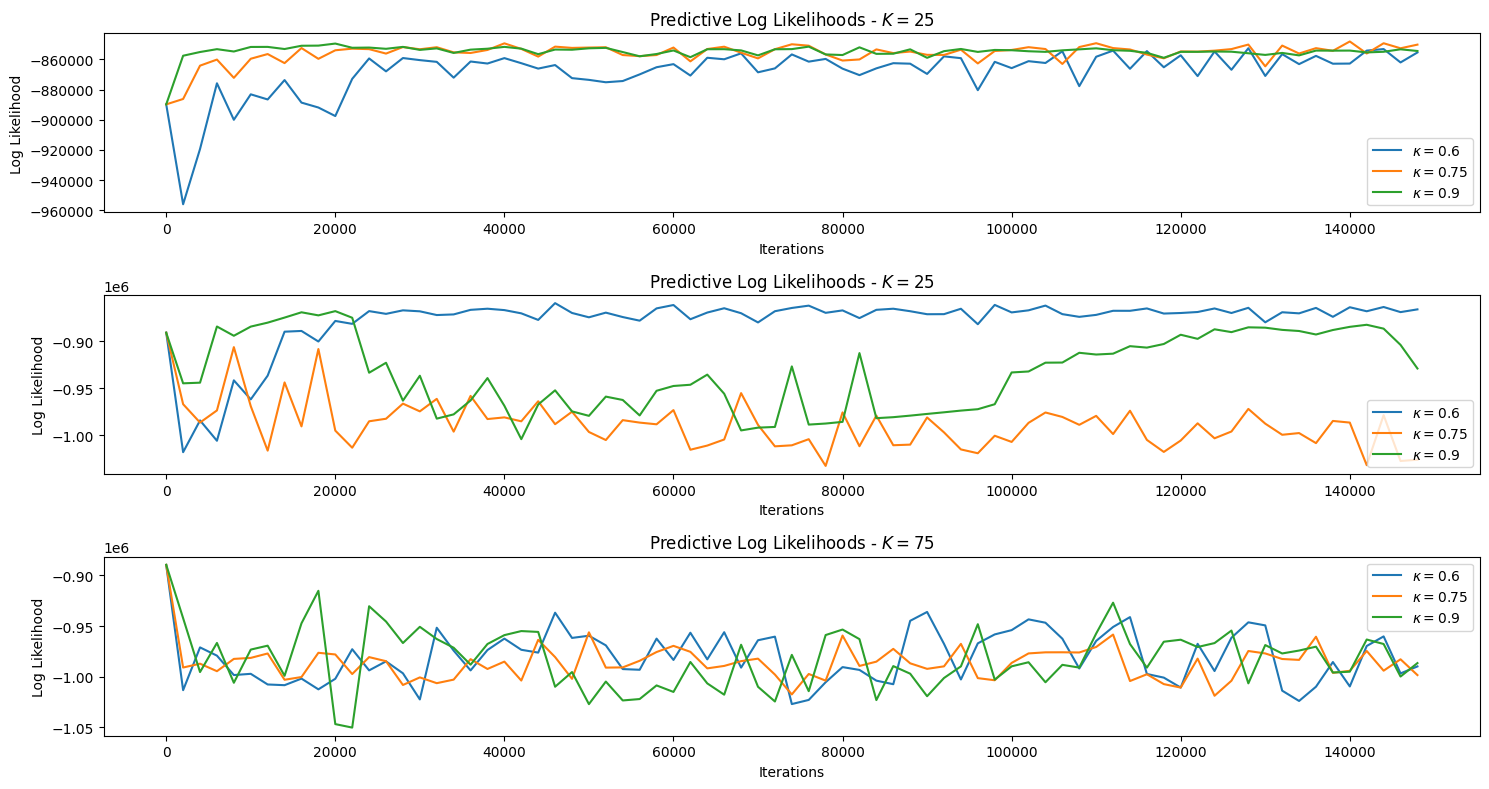

In [ ]:
fig, axs = plt.subplots(3, figsize=(15, 8))

# K=25
axs[0].plot(np.arange(0, 150000, 2000), kappa_06_K_25, label=r'$\kappa=0.6$')
axs[0].plot(np.arange(0, 150000, 2000), kappa_075_K_25, label=r'$\kappa=0.75$')
axs[0].plot(np.arange(0, 150000, 2000), kappa_09_K_25, label=r'$\kappa=0.9$')
axs[0].set_title(r'Predictive Log Likelihoods - $K=25$')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Log Likelihood')
axs[0].legend()

# K=50
axs[1].plot(np.arange(0, 150000, 2000), kappa_06_K_50, label=r'$\kappa=0.6$')
axs[1].plot(np.arange(0, 150000, 2000), kappa_075_K_50, label=r'$\kappa=0.75$')
axs[1].plot(np.arange(0, 150000, 2000), kappa_09_K_50, label=r'$\kappa=0.9$')
axs[1].set_title(r'Predictive Log Likelihoods - $K=50$')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Log Likelihood')
axs[1].legend()

# K=75
axs[2].plot(np.arange(0, 150000, 2000), kappa_06_K_75, label=r'$\kappa=0.6$')
axs[2].plot(np.arange(0, 150000, 2000), kappa_075_K_75, label=r'$\kappa=0.75$')
axs[2].plot(np.arange(0, 150000, 2000), kappa_09_K_75, label=r'$\kappa=0.9$')
axs[2].set_title(f'Predictive Log Likelihoods - $K=75$')
axs[2].set_xlabel('Iterations')
axs[2].set_ylabel('Log Likelihood')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


First of all we note that the smaller the number of topics, the better the more stable the algorithms with respect to predictive log likelihood. For $K=25$ all choices of $\kappa$ seem to converge, while for $K=50$ and $\kappa=0.9$ the behaviour is very unstable. For the largest choice of $K=75$ no choice of forgetting rate seems to lead to convergence of the predictive likelihood. In conclusion it seems to be generally preferable to choose $\kappa$ relatively small for $K$ large and $\kappa$ large for $K$ comparatively small. The choice of $K$ naturally depends on the structure of the corpus. In our case $K=25$ worked best among the considered values for the chosen performance metric.

However we remark that the predictive likelihood, especially when computed on a small number of held out documents (as in our case due to computational constraints) can only give a very noisy estimate of the performance.The many causes of uncertainty stemming from the choice of held out documents and the choice of hidden and observed words.

## Illustration

To conclude we want to illustrate the topics that were estimated by the choice of parameters that seems to have worked best ($K=25$, $\kappa=0.9$). We will print the word with the highest probabilities for each topic and visualize the topic distributions as a heatmap.

In [ ]:
# Matrix with topic distributions
lambda_norm = np.array(result_dict['6']['lambda'])

In [ ]:
# Print words with highest probability for each topic
num_top_words = 10
K = result_dict['6']['K']
for i in range(K):
    print(f"Top words in Topic {i+1}")
    print([terms[ind] for ind in np.argsort(lambda_norm[i])[-num_top_words:][::-1]])
    print("-"*30)

Top words in Topic 1
['data', 'value', 'research', 'systems', 'technology', 'program', 'students', 'computer', 'information', 'test']
------------------------------
Top words in Topic 2
['president', 'irish', 'union', 'ireland', 'government', 'council', 'secretary', 'republic', 'police', 'office']
------------------------------
Top words in Topic 3
['school', 'church', 'john', 'century', 'age', 'high', 'museum', 'family', 'schools', 'catholic']
------------------------------
Top words in Topic 4
['french', 'german', 'france', 'art', 'italian', 'born', 'paris', 'works', 'society', 'italy']
------------------------------
Top words in Topic 5
['company', 'act', 'government', 'companies', 'public', 'property', 'services', 'building', 'including', 'business']
------------------------------
Top words in Topic 6
['language', 'used', 'word', 'term', 'common', 'study', 'form', 'european', 'culture', 'use']
------------------------------
Top words in Topic 7
['film', 'films', 'love', 'directed',

Although it is not the case for all topics, from a human perspective some of these topics seem make sense, e.g. Topic 1 seems to be related to the IT industry putting high probabilities on words like data, systems, computer, technology and information
Topic 9 emphasizes words related to sports, Topic 11 words with connotations of the military, Topic 16 on politics related word and Topic 18 on words related to the music industry.

In [ ]:
def visualize_topic_distributions(lambda_norm, terms, num_top_words=10):
    """
    Visualize the topic-word distributions.

    Parameters:
    lambda_norm (numpy.ndarray): Normalized topic-word distribution matrix of shape (number of topics, vocabulary size).
    terms (list): List of terms corresponding to the vocabulary.
    num_top_words (int): Number of top words to select from each topic (default is 10).

    This function visualizes the topic-word distributions using a heatmap.
    It selects the top words for each topic based on their probabilities and creates a heatmap to display the distributions.
    """
    top_word_indices = np.unique(np.argsort(lambda_norm, axis=1)[:, :-num_top_words-1:-1])
    lambda_norm_top = lambda_norm[:, top_word_indices]
    topwords = [terms[ind] for ind in top_word_indices]
    plt.figure(figsize=(40, 12))
    sns.heatmap(lambda_norm_top, cmap='viridis', xticklabels=topwords)
    plt.title('Topic-word Distribution')
    plt.xlabel('Words')
    plt.ylabel('Topics')
    plt.show()

Below we show a heatmap of the topic distributions. The colours represent the probability each topic places on the words.

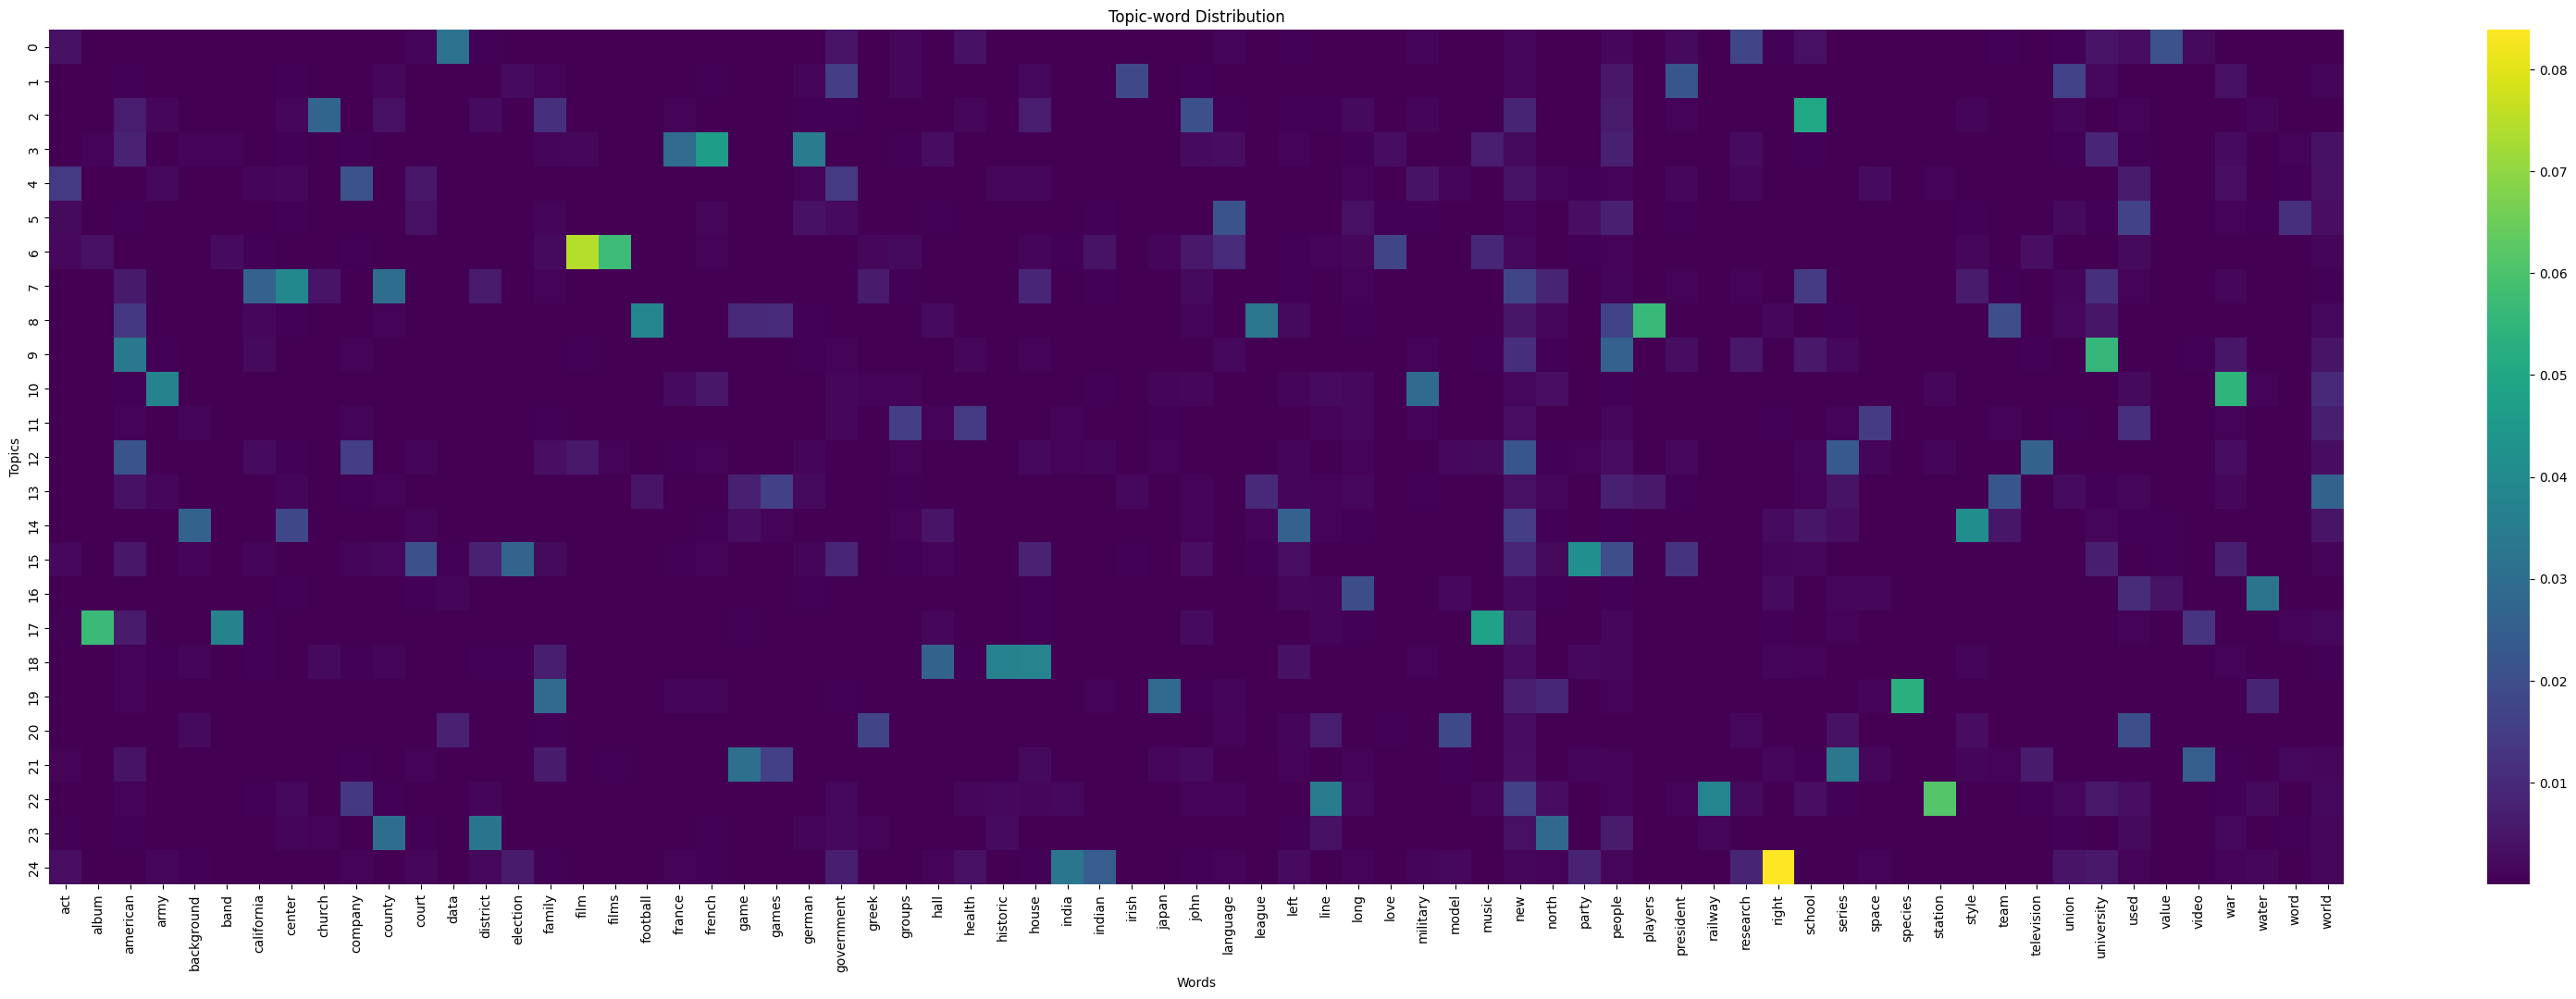

In [ ]:
visualize_topic_distributions(lambda_norm, terms, num_top_words=3)